# Music and the Brain 



## 0. Setup and load data from 0.[decoding]feature-extraction notebook.

In [1]:
import os 


import nilearn

import numpy as np
import pandas as pd

import nibabel as nib

from nilearn import plotting
from nilearn import image
from nilearn.plotting import plot_anat, plot_img, plot_stat_map


In [2]:
# Set the path to the data directory
src_dir = '../data/derivatives/nilearn'

# Set the participant and session IDs
part_id = 'sub-02'
ses_id = 'ses-01'



In [3]:
data_dir = os.path.join(src_dir, part_id, ses_id)


In [4]:
# Load feature set.
X = image.load_img(os.path.join(data_dir, f'{part_id}_{ses_id}_task-02a-MVPA-12sBOLD.nii.gz'))

# Load csv file with targets.
target_set = pd.read_csv(os.path.join(data_dir, f'{part_id}_{ses_id}_task-02a-MVPA-12sBOLD_targets.csv'))

# Load csv file with groups.
group_set = pd.read_csv(os.path.join(data_dir, f'{part_id}_{ses_id}_task-02a-MVPA-12sBOLD_groups.csv'))


In [5]:
# Load mask.
mask_img = image.load_img(os.path.join(data_dir, f'{part_id}_{ses_id}_task-02a-MVPA_multi-epi-mask.nii.gz'))

# 1. Classification

In [6]:
from nilearn.maskers import NiftiMasker
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneGroupOut

from nilearn.decoding import Decoder
# “background”: Use this option if your images present a clear homogeneous background.
# “whole-brain-template”: This will extract the whole-brain part of your data by resampling 
# the MNI152 brain mask for your data’s field of view.


logo = LeaveOneGroupOut()



In [7]:
# concat images in list
# X = nilearn.image.concat_imgs(list(image_set.values()))
print(X.shape)


(97, 115, 97, 72)


## 1.1 Create target vector

In [8]:
y = list(target_set['target'].values)

# transform the target_set unique strings to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# 0 agaisnt all others
# y = np.where(y == 1, 0, 1)

print(y)



[2 2 5 5 7 7 0 0 3 3 1 1 6 6 4 4 8 8 0 0 7 7 1 1 2 2 3 3 4 4 8 8 6 6 5 5 7
 7 4 4 1 1 8 8 2 2 5 5 0 0 6 6 3 3 2 2 5 5 1 1 6 6 4 4 3 3 7 7 0 0 8 8]


In [9]:
runs_group = group_set['group'].values

print(runs_group)

# unique values in runs_group
print(np.unique(runs_group))


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[0 1 2 3]


## 1.2 Classification model

### 1.2.1 Nilearn wrapper

In [10]:
scoring_method = 'roc_auc'

decoder = Decoder(
    estimator='svc', 
    cv = logo, 
    smoothing_fwhm = 3,  
    mask = mask_img,
    standardize=True,
    scoring=scoring_method,
    )

#### 1.2.1.1 Train model

In [11]:
decoder.fit(
    X, 
    y, 
    groups = runs_group)


/Users/brunoleitao/anaconda3/envs/mvpa/lib/python3.12/site-packages/joblib/memory.py:353: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


#### 1.2.1.2 Cross validation results

In [12]:

# get values of decoder_LogisticL1.cv_scores_ per fold and create list
cv_scores = [decoder.cv_scores_[i] for i in range(len(decoder.cv_scores_))]

# mean of cv_scores per class
cv_scores_mean = np.mean(cv_scores, axis=1)

# create pandas dataframe with cv_scores_mean and labels
df = pd.DataFrame(cv_scores_mean, columns=['score'])
df['label'] = le.classes_

# print the dataframe
print(df)

print(np.mean(cv_scores_mean))


      score             label
0  0.468750  JoyfulActivation
1  0.554688         Nostalgia
2  0.578125      Peacefulness
3  0.695312             Power
4  0.671875           Sadness
5  0.585938        Tenderness
6  0.718750           Tension
7  0.585938     Transcendence
8  0.632812            Wonder
0.6102430555555556


In [13]:
# save results cv_scores_mean into a csv file with columns: target, cv_score
results_dir = '../results'
if not os.path.exists(os.path.join(results_dir, 'nilearn', part_id)):
    os.makedirs(os.path.join(results_dir, 'nilearn', part_id))

fn = f'{part_id}_{ses_id}_task-02a_MVPA12sBOLD_cv-scores.csv'

df = pd.DataFrame({'target': le.classes_, 'cv_score': cv_scores_mean, 'classifier': 'svc_nilearn_wrapper', 'scoring': scoring_method})

# read the csv file and append the new data
if os.path.exists(os.path.join(results_dir, 'nilearn', part_id, fn)):
    
    df = pd.read_csv(os.path.join(results_dir, 'nilearn', part_id, fn))

    # add new data to df
    df = pd.concat([df, pd.DataFrame({'target': le.classes_, 'cv_score': cv_scores_mean, 'classifier': 'svc_nilearn_wrapper', 'scoring': scoring_method})])

df.to_csv(os.path.join(results_dir, 'nilearn', part_id, fn), index=False)


## 2.2 Dummy predictor

In [14]:
# randomize y in sets of unique runs_groups
y_random = np.array(y)
for i in np.unique(runs_group):
    y_random[runs_group == i] = np.random.permutation(y_random[runs_group == i])


decoder_random = Decoder(
    estimator='svc', 
    cv = logo, 
    smoothing_fwhm = 3,  
    mask = mask_img,
    standardize="zscore_sample")

decoder_random.fit(
    X, 
    y_random, 
    groups = runs_group)


In [15]:
# get values of decoder_LogisticL1.cv_scores_ per fold and create list
cv_scores_random = [decoder_random.cv_scores_[i] for i in range(len(decoder_random.cv_scores_))]

# mean of cv_scores per class
cv_scores_mean_random = np.mean(cv_scores_random, axis=1)

print(cv_scores_mean_random)

print(np.mean(cv_scores_mean_random))

[0.5390625 0.65625   0.5546875 0.4921875 0.40625   0.1875    0.46875
 0.4453125 0.5234375]
0.4748263888888889


In [16]:
decoder_dummy = Decoder(
    estimator='dummy_classifier', 
    cv = logo, 
    smoothing_fwhm = 3,  
    mask = mask_img,
    standardize="zscore_sample")

decoder_dummy.fit(
    X, 
    y, 
    groups = runs_group)

In [17]:
# get values of decoder_LogisticL1.cv_scores_ per fold and create list
cv_scores_dummy = [decoder_dummy.cv_scores_[i] for i in range(len(decoder_dummy.cv_scores_))]

# mean of cv_scores per class
cv_scores_mean_dummy = np.mean(cv_scores_dummy, axis=1)

print(cv_scores_mean_dummy)

print(np.mean(cv_scores_mean_dummy)
)

[0.546875  0.40625   0.546875  0.546875  0.4765625 0.40625   0.546875
 0.4765625 0.546875 ]
0.5


## 2.3 Plotting weights

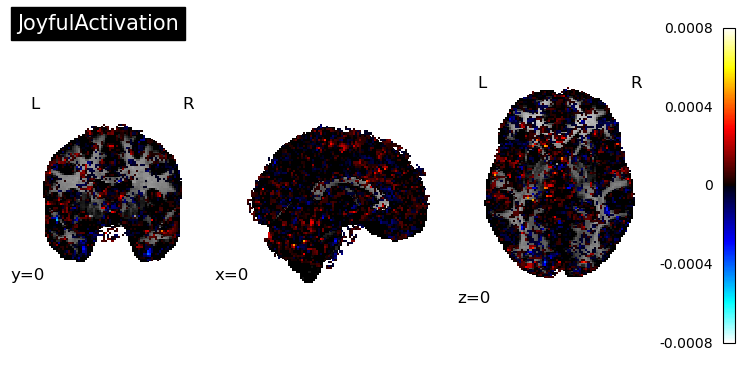

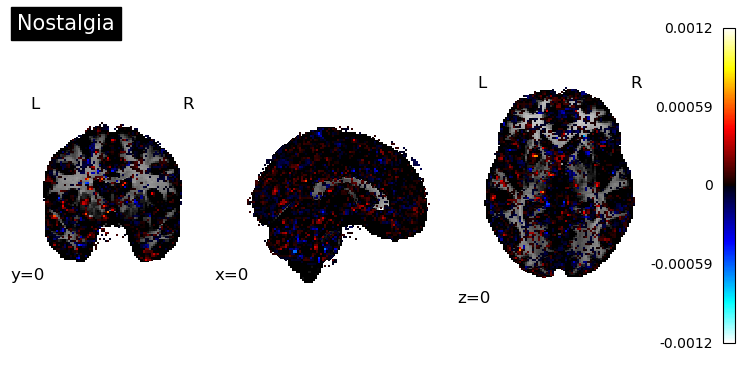

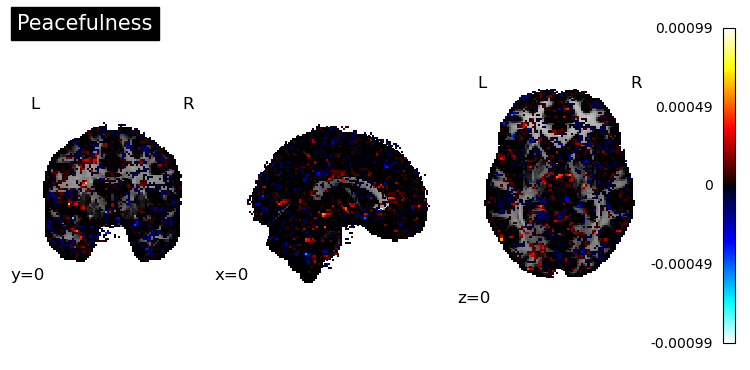

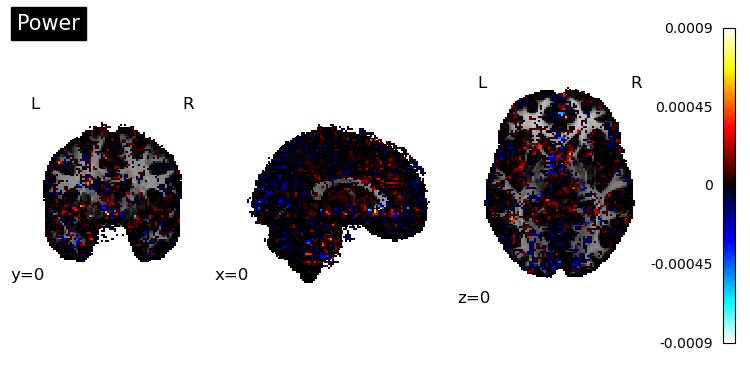

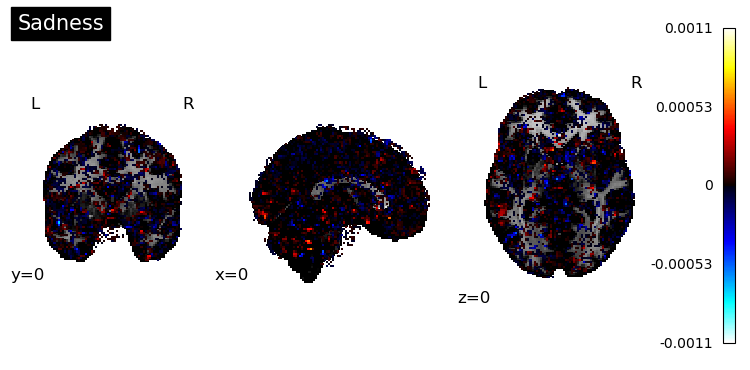

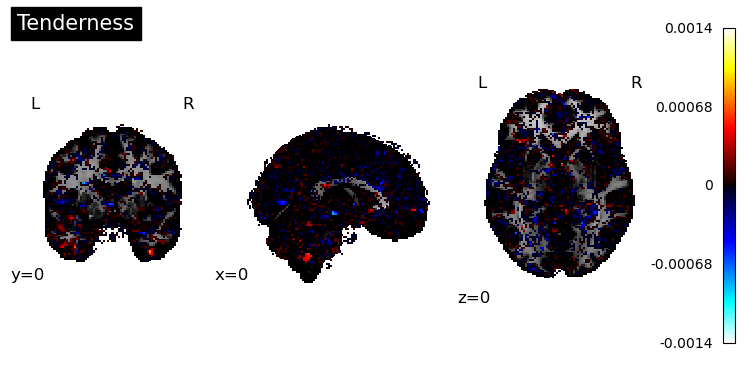

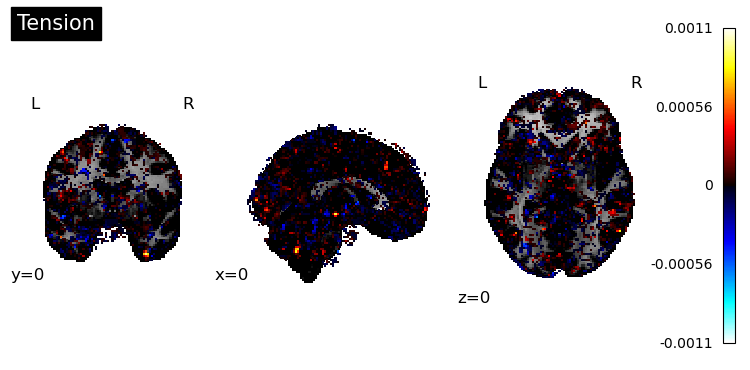

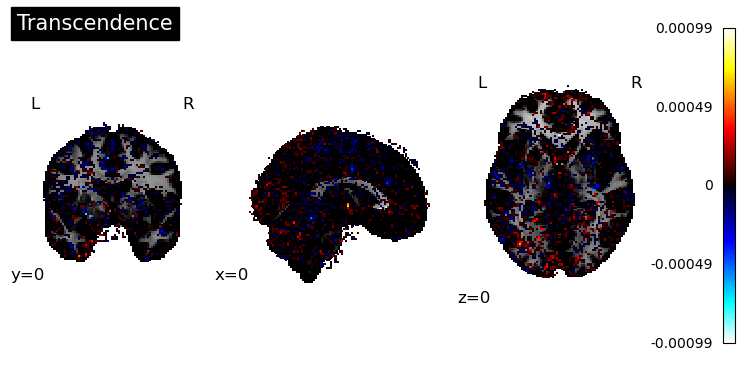

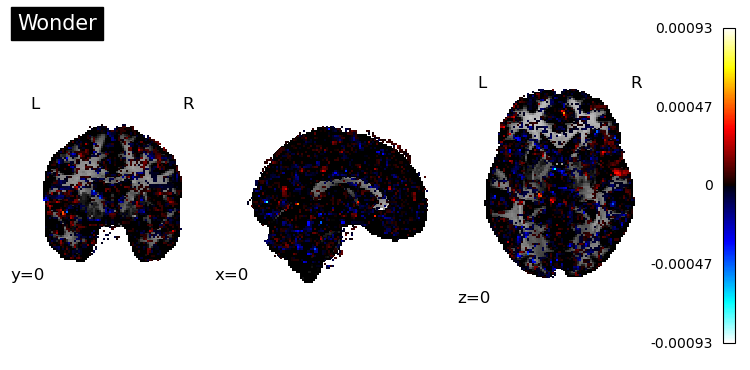

In [18]:
# Create a plot for each emotion

for i in range(len(np.unique(y))):

    # get the indices of the target_set
    idx = np.where(y == i)

    # plot the cv_scores_mean_i
    plt = plotting.plot_stat_map(
        decoder.coef_img_[i],
        title=f'{le.inverse_transform([i])[0]}',
        dim=-1,
        threshold="auto",
        cut_coords=(0, 0, 0),
        draw_cross=False,
    )

    # save the plot
    # plt.savefig(os.path.join(results_dir, f'{part_id}_{ses_id}_task-02a_MVPA_12sBOLD_{le.inverse_transform([i])[0]}.png'))


Average Weights across folds

In [19]:
# shape
list(decoder.coef_img_.values())

In [20]:
# crete mean image of the images in dict decoder.coef_img_
from nilearn.image import mean_img



# compute sum of all images in list

# for each image in the list extract the data and sum them
imgs = decoder.coef_img_.values()

# create list img_data
img_data = []

i = 0
for img in imgs:
    # compute the absolute value of the image data
    img_data.append(np.abs(img.get_fdata()))

    i += 1





# mean_img_coef = mean_img(list(decoder.coef_img_.values()))



In [21]:
img_data = np.array(img_data)

In [22]:
# mean of the images
mean_img_coef = np.sum(img_data, axis=0)

In [23]:
#create image from mean_img_coef
mean_img_coef = nib.Nifti1Image(mean_img_coef, mask_img.affine)


/Users/brunoleitao/anaconda3/envs/mvpa/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



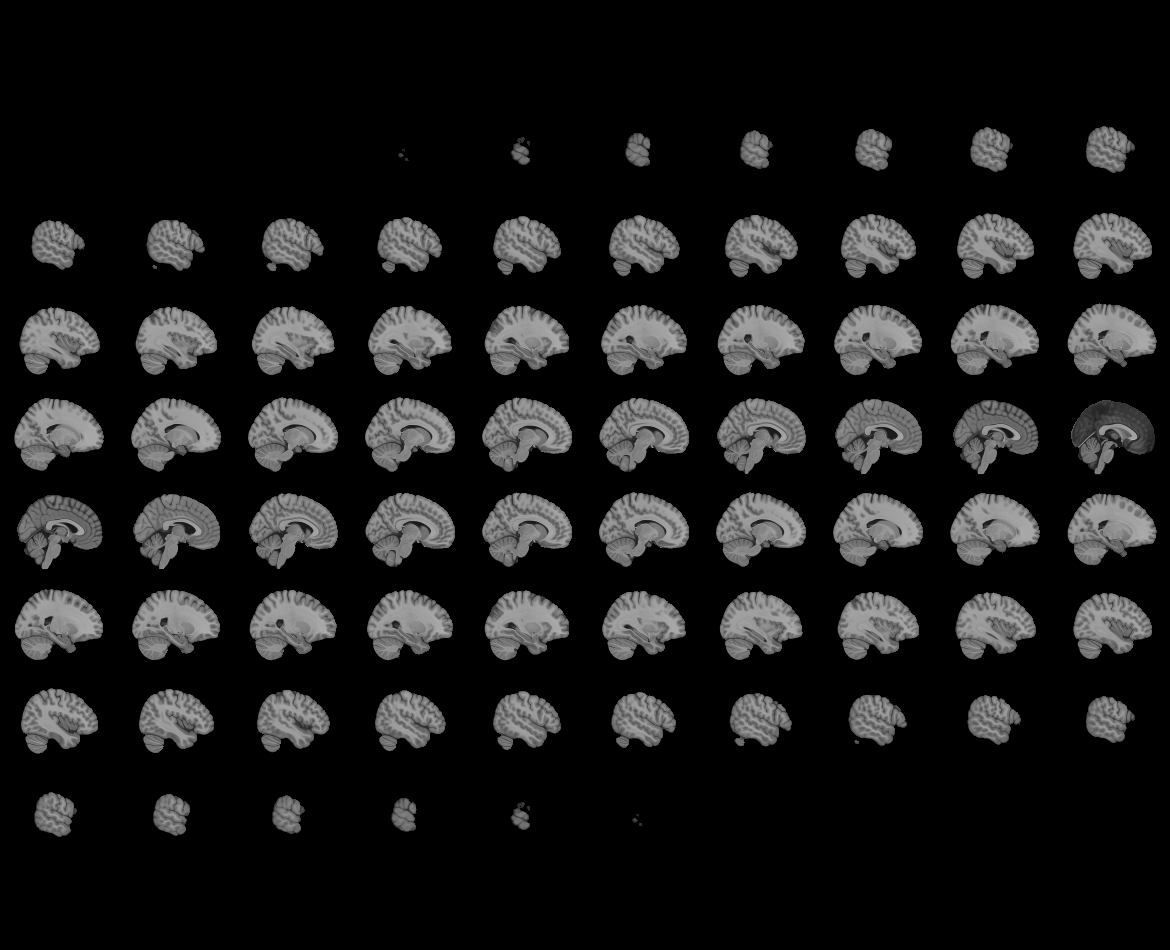
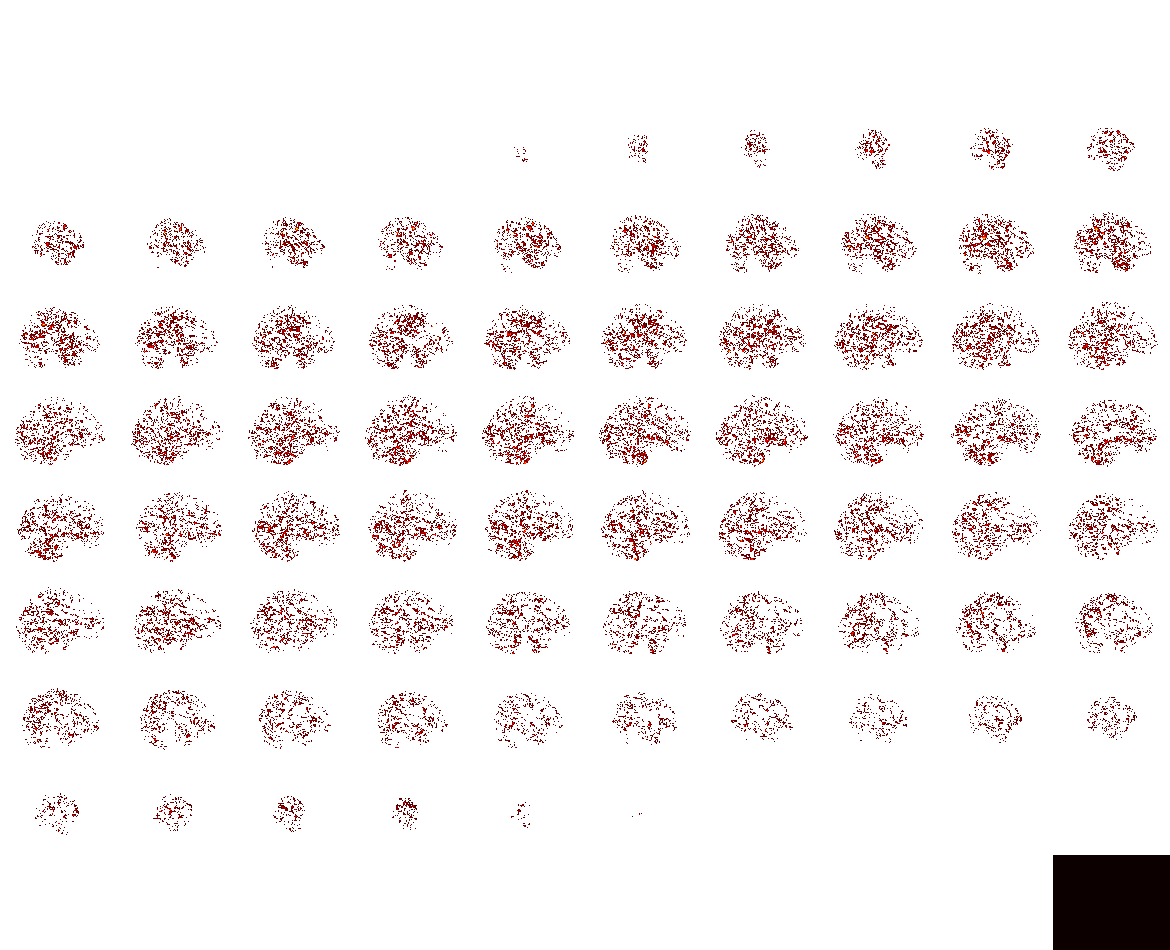

In [32]:
# plot the cv_scores_mean_i
plotting.view_img(
    mean_img_coef,
    title='mean image',
    threshold="95%",
    cut_coords=(0, 0, 0),
    draw_cross=True,)



# 3. Classification using scikit routines

In [25]:
from nilearn.maskers import NiftiMasker

# Extract data using masker


masker = NiftiMasker(mask_img = mask_img, 
                    smoothing_fwhm=3,
                    standardize="zscore_sample",)

X_data = masker.fit_transform(X)


print('shape of X:', X_data.shape)

# feature selection based on anova
from sklearn.feature_selection import SelectKBest, f_classif

# create an instance of SelectKBest
selector = SelectKBest(f_classif, k=52000)

# fit the selector to the data
selector.fit(X_data, y)

# get the indices of the selected features
idx = selector.get_support(indices=True)

# get the scores of the selected features
scores = selector.scores_[idx]

# get the p-values of the selected features
pvalues = selector.pvalues_[idx]

# get the selected features
X_data_selected = X_data[:, idx]

print('shape of X_selected:', X_data_selected.shape)

shape of X: (72, 231043)
shape of X_selected: (72, 52000)


In [26]:

# number of unique in runs_group
n_splits = len(np.unique(runs_group))

logo = LeaveOneGroupOut()

#for train, test in logo.split(X_data, y, groups=runs_group):
#   print("%s %s" % (train, test))

In [27]:
from sklearn.metrics import roc_auc_score

def roc_auc_score_multiclass(actual_class, pred_class, average, multi_class):

  #creating a set of all the unique classes using the actual class list
  unique_class = set(actual_class)
  roc_auc_dict = {}
  for per_class in unique_class:
    #creating a list of all the classes except the current class 
    other_class = [x for x in unique_class if x != per_class]

    #marking the current class as 1 and all other classes as 0
    new_actual_class = [0 if x in other_class else 1 for x in actual_class]
    new_pred_class = [0 if x in other_class else 1 for x in pred_class]

    #using the sklearn metrics method to calculate the roc_auc_score
    roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average, multi_class = multi_class)
    roc_auc_dict[per_class] = roc_auc

  return roc_auc_dict

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneGroupOut

from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score


clf = svm.SVC()

accuracy = {}
lr_roc_auc_multiclass  = {}
roc_vals_mc = {}
cm = {}

f = 0

for train, test in logo.split(X_data_selected, y, groups=runs_group): 
    # print("%s %s" % (train, test))
    X_train, X_test = X_data_selected[train], X_data_selected[test]
    y_train, y_test = y[train], y[test]

    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    clf.fit(X_train, y_train)

    # predict the labels
    y_pred = clf.predict(X_test)
    # y_pred_prob = clf.predict_proba(X_test)

    # compute the confusion matrix
    cm[f] = confusion_matrix(y_test, y_pred)

    # We will store the results in a dictionary for easy access later
    per_class_accuracies = {}

    # Calculate the accuracy for each one of our classes
    for idx, cls in enumerate(set(y_test)):
        # True negatives are all the samples that are not our current GT class (not the current row) and were not predicted as the current class (not the current column)
        true_negatives = np.sum(np.delete(np.delete(cm[f], idx, axis=0), idx, axis=1))
        
        # True positives are all the samples of our current GT class that were predicted as such
        true_positives = cm[f][idx, idx]
        
        # The accuracy for the current class is the ratio between correct predictions to all predictions
        per_class_accuracies[cls] = (true_positives + true_negatives) / np.sum(cm[f])

    accuracy[f] = per_class_accuracies


    # compute the ROC
    roc_vals = roc_auc_score_multiclass(y_test, y_pred, average = 'micro', multi_class = 'ovr')


    lr_roc_auc_multiclass[f] = list(roc_vals.values())


    # roc_vals_mc[f] = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')

    f += 1
    
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {lr_roc_auc_multiclass}')

Accuracy: {0: {0: 0.3333333333333333, 1: 0.8888888888888888, 2: 0.7777777777777778, 3: 0.8888888888888888, 4: 0.8333333333333334, 5: 0.8888888888888888, 6: 0.9444444444444444, 7: 0.8888888888888888, 8: 0.8888888888888888}, 1: {0: 0.4444444444444444, 1: 0.7777777777777778, 2: 0.8888888888888888, 3: 0.8888888888888888, 4: 0.8333333333333334, 5: 0.8333333333333334, 6: 0.8888888888888888, 7: 0.7777777777777778, 8: 0.8888888888888888}, 2: {0: 0.8888888888888888, 1: 0.8888888888888888, 2: 0.6111111111111112, 3: 0.8888888888888888, 4: 0.7222222222222222, 5: 0.8333333333333334, 6: 0.5, 7: 0.8888888888888888, 8: 0.8888888888888888}, 3: {0: 0.8888888888888888, 1: 0.8333333333333334, 2: 0.8888888888888888, 3: 0.6666666666666666, 4: 0.7222222222222222, 5: 0.7222222222222222, 6: 0.8888888888888888, 7: 0.8333333333333334, 8: 0.8888888888888888}}
ROC AUC: {0: [0.1875, 0.5, 0.4375, 0.71875, 0.46875, 0.5, 0.75, 0.71875, 0.5], 1: [0.25, 0.4375, 0.5, 0.5, 0.46875, 0.46875, 0.5, 0.875, 0.5], 2: [0.5, 0.5,

In [29]:
# get values of accuracy per fold and create list
cv_accuracy = [list(accuracy[i].values()) for i in range(len(accuracy))]


print(cv_accuracy)





[[0.3333333333333333, 0.8888888888888888, 0.7777777777777778, 0.8888888888888888, 0.8333333333333334, 0.8888888888888888, 0.9444444444444444, 0.8888888888888888, 0.8888888888888888], [0.4444444444444444, 0.7777777777777778, 0.8888888888888888, 0.8888888888888888, 0.8333333333333334, 0.8333333333333334, 0.8888888888888888, 0.7777777777777778, 0.8888888888888888], [0.8888888888888888, 0.8888888888888888, 0.6111111111111112, 0.8888888888888888, 0.7222222222222222, 0.8333333333333334, 0.5, 0.8888888888888888, 0.8888888888888888], [0.8888888888888888, 0.8333333333333334, 0.8888888888888888, 0.6666666666666666, 0.7222222222222222, 0.7222222222222222, 0.8888888888888888, 0.8333333333333334, 0.8888888888888888]]


In [30]:
# compute mean of the ROC AU
mean_roc_auc = np.mean(list(lr_roc_auc_multiclass.values()), axis=0)

print(f'Mean ROC AUC: {mean_roc_auc}')



# compute mean of the accuracy
mean_accuracy = np.mean(cv_accuracy, axis=0)

print(f'Mean accuracy: {mean_accuracy}')


Mean ROC AUC: [0.359375  0.4765625 0.4453125 0.6328125 0.4375    0.4609375 0.5625
 0.6953125 0.5      ]
Mean accuracy: [0.63888889 0.84722222 0.79166667 0.83333333 0.77777778 0.81944444
 0.80555556 0.84722222 0.88888889]


Text(50.72222222222221, 0.5, 'True')

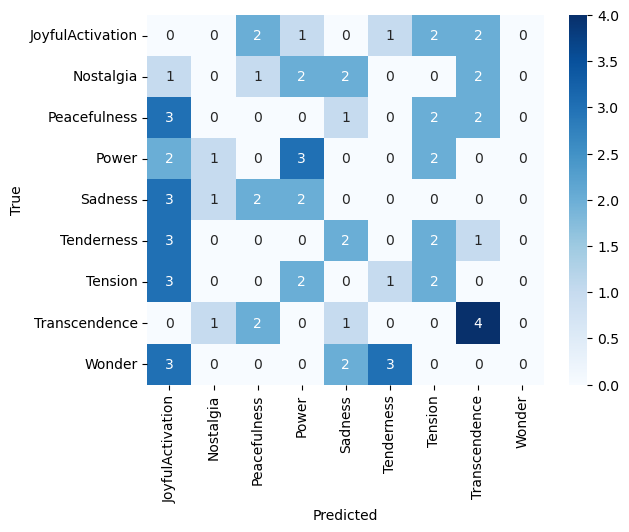

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sns

# plot confusion matrix totals
cm_total = np.zeros(cm[0].shape)

for i in range(len(cm)):
    cm_total += cm[i]



sns.heatmap(cm_total, annot= True, fmt='g', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_, )

plt.xlabel('Predicted')
plt.ylabel('True')